In [1]:
import numpy as np
import torch
import nibabel as nib

from utils.SAMMed3D_segment_anything.build_sam3D import build_sam3D_vit_b_ori
from classes.SAMMed3DClass import SAMMed3DInferer, SAMMed3DWrapper

import utils.promptUtils as prUt
import utils.analysisUtils as anUt

def load_sammed3d(checkpoint_path, device = 'cuda'):
    device = 'cuda'
    checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d.pth'

    sam_model_tune = build_sam3D_vit_b_ori(checkpoint=None)
    if checkpoint_path is not None:
        model_dict = torch.load(checkpoint_path, map_location=device)
        state_dict = model_dict['model_state_dict']
        sam_model_tune.load_state_dict(state_dict)

    return (sam_model_tune)

def read_im_gt(img_path, gt_path):
    img, gt = nib.load(img_path), nib.load(gt_path)

    ## Check if the volume is already in RAS+
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Image not in RAS. Consider reorienting here')
        img_ras = nib.as_closest_canonical(volume_img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Label not in RAS. Consider reorienting here')
        gt_ras = nib.as_closest_canonical(gt)

    img, gt = img.get_fdata().astype(np.float32), gt.get_fdata().astype(int)

    return(img, gt)

# Obtain model and inputs
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d.pth'
sammed3d_model = load_sammed3d(checkpoint_path, device)

img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
img, gt = read_im_gt(img_path, gt_path)

pts_prompt = prUt.get_pos_clicks3D(gt, 5)


# Perform infrence
SAMMed3D_wrapper = SAMMed3DWrapper(sammed3d_model, device)
segmenter = SAMMed3DInferer(SAMMed3D_wrapper)
segmentation = segmenter.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

0.7474433583818295

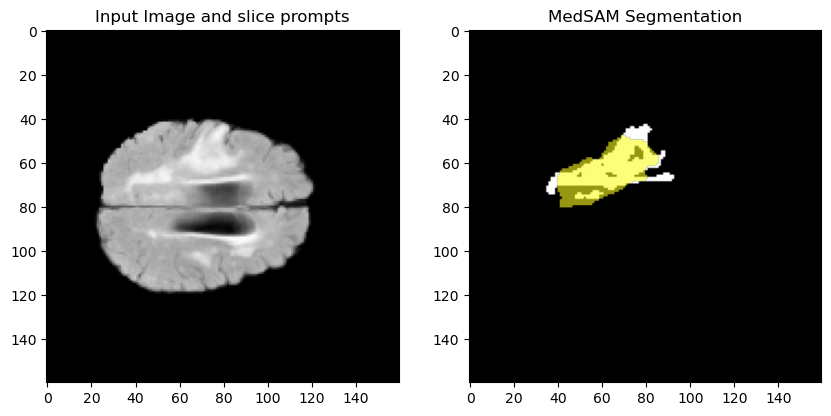

0.7208569628229363

In [2]:
slice_idx = 65
anUt.show_seg(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)